# F20AA Coursework 2


In [ ]:
import googleapiclient.discovery
import googleapiclient.errors
import numpy as np
import pandas as pd
import glob
import nltk 
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from langdetect import detect
import shutil
import random
from wordcloud import WordCloud
import gensim
import seaborn as sns
from textblob import TextBlob
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.datasets import load_files
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score


nltk.download('vader_lexicon')
nltk.download('stopwords')

## 1) Data Exploration and Visualization:


In [ ]:
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')

In [ ]:
train_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df.isna().any().any()

In [ ]:
# Check for null values in the DataFrame
null_values = train_df.isnull().sum()
print(null_values)

In [ ]:
# Filter rows with at least one null value
rows_with_null = train_df[train_df.isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null values:")
print(rows_with_null)

In [ ]:
# Drop rows with null values
train_df = train_df.dropna()

In [ ]:
# Filter rows with at least one null value
rows_with_null = train_df[train_df.isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null values:")
print(rows_with_null)

In [ ]:
review_distribution = train_df['overall'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(review_distribution, labels=review_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Rating Distribution')
plt.axis('equal')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
# color=['#9CA3D6','#CFC1E8', '#F2D5EF', '#F7EFDA', '#B3DDC4']
plt.bar(review_distribution.index, review_distribution.values, color=['#9CA3D6','#CFC1E8', '#F2D5EF', '#F7EFDA', '#B3DDC4'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Frequency')
plt.show()

In [ ]:
# Grouped in descending order
grouped = train_df.groupby('overall')

# Generate word cloud for each rating
for rating, group in grouped:
    text = ' '.join(group['Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(f'Word Cloud for Rating {rating}')
    plt.axis('off')
    plt.show()

In [ ]:
# train_df['text_length'] = train_df['Review'].apply(len)

# plt.figure(figsize=(10, 6))
# sns.boxplot(x='overall', y='text_length', data=train_df)
# plt.title('Length of Text for Each Rating')
# plt.xlabel('Rating')
# plt.ylabel('Text Length')
# plt.show()

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))

# def preprocess_text(text):
#     tokens = word_tokenize(text.lower())  
#     tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
#     return tokens

# train_df['processed_text'] = train_df['Review'].apply(preprocess_text)

# sentiment_word_freq = {i: {} for i in range(1, 6)}

# for i, row in train_df.iterrows():
#     sentiment = row['overall']
#     for word in row['processed_text']:
#         sentiment_word_freq[sentiment][word] = sentiment_word_freq[sentiment].get(word, 0) + 1

# def plot_top_words(top_words_dict):
#     fig, axes = plt.subplots(nrows=1, ncols=len(top_words_dict), figsize=(15, 6), sharey=True)
#     for sentiment, top_words in top_words_dict.items():
#         ax = axes[sentiment - 1]
#         words, frequencies = zip(*top_words)
#         ax.bar(words, frequencies, color='blue')
#         ax.set_xlabel('Words')
#         ax.set_ylabel('Frequency')
#         ax.set_title(f'Top 10 Words for Rating {sentiment}')
#         ax.tick_params(axis='x', rotation=45, labelsize=10)
#     plt.tight_layout()
#     plt.show()

# top_words_by_sentiment = {}
# for sentiment, word_freq in sentiment_word_freq.items():
#     top_words_by_sentiment[sentiment] = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]

# plot_top_words(top_words_by_sentiment)


## 2) Text Processing and Normalization:


In [ ]:
def remove_punctuation(text):
    # Define the pattern to match punctuation
    punctuation_pattern = r'[^\w\s]'
    # Replace punctuation with an empty string
    text_without_punctuation = re.sub(punctuation_pattern, '', text)
    # Normalize whitespace
    normalized_text = re.sub(r'\s+', ' ', text_without_punctuation)
    return normalized_text

# Text Processing
def preprocess_text(text, method='snowballstemming'):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())

    # Define the set of stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords and punctuation
    tokens = [remove_punctuation(token) for token in tokens if token.isalnum() and token not in stop_words]
    
    if method == 'snowballstemming':
        stemmer = nltk.stem.SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]

    elif method == 'porterstemming':
        stemmer = nltk.stem.PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    elif method == 'lemmatization':
        lemmatizer = nltk.stem.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [ ]:
train_df['ssprocessing_text'] = train_df['Review'].apply(preprocess_text, method='snowballstemming')
train_df['psprocessing_text'] = train_df['Review'].apply(preprocess_text, method='porterstemming')
train_df['lemprocessing_text'] = train_df['Review'].apply(preprocess_text, method='lemmatization')

In [ ]:
train_df

### Feature Representation - Reviews


In [ ]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['Review'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks if word appears in a sentence 
subset_df=train_df['Review'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
subset_df=train_df['Review'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

In [ ]:
subset_df=train_df['Review'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

In [ ]:
w2v_path = "FR_models/W2V"
ft_path = "FR_models/FT"

if not os.path.exists(w2v_path):
    os.makedirs(w2v_path, exist_ok=True)
if not os.path.exists(ft_path):
    os.makedirs(ft_path, exist_ok=True)

In [ ]:
subset_df = train_df['Review'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v_r = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft_r = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v_r.save("FR_models/W2V/model_w2v_r.model")
model_ft_r.save("FR_models/FT/model_ft_r.model")

# Load the models from disk
model_w2v_r = gensim.models.Word2Vec.load("FR_models/W2V/model_w2v_r.model")
model_ft_r = gensim.models.FastText.load("FR_models/FT/model_ft_r.model")

In [ ]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v_r.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v_r.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v_r.wv.most_similar(positive=['pen', 'marker'], topn=5))
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"machine\"\n",model_w2v_r.wv.most_similar(positive=['marker', 'pen'], negative=['machine'], topn=5))

### Feature Representation - Snowball Stemmer


In [ ]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['ssprocessing_text'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks if word appears in a sentence 
subset_df=train_df['ssprocessing_text'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
subset_df=train_df['ssprocessing_text'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

In [ ]:
subset_df=train_df['ssprocessing_text'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

In [ ]:
subset_df = train_df['ssprocessing_text'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v_ss = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft_ss = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v_ss.save("FR_models/W2V/model_w2v_ss.model")
model_ft_ss.save("FR_models/FT/model_ft_ss.model")

# Load the models from disk
model_w2v_ss = gensim.models.Word2Vec.load("FR_models/W2V/model_w2v_ss.model")
model_ft_ss = gensim.models.FastText.load("FR_models/FT/model_ft_ss.model")

In [ ]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v_ss.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v_ss.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v_ss.wv.most_similar(positive=['pen', 'marker'], topn=5))

# not sure about this - the negative board
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"board\"\n",model_w2v_ss.wv.most_similar(positive=['marker', 'pen'], negative=['board'], topn=5))

### Feature Representation - Porter Stemmer


In [ ]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['psprocessing_text'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks if word appears in a sentence 
subset_df=train_df['psprocessing_text'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
subset_df=train_df['psprocessing_text'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

In [ ]:
subset_df=train_df['psprocessing_text'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

In [ ]:
subset_df = train_df['psprocessing_text'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v_ps = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft_ps = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v_ps.save("FR_models/W2V/model_w2v_ps.model")
model_ft_ps.save("FR_models/FT/model_ft_ps.model")

# Load the models from disk
model_w2v_ps = gensim.models.Word2Vec.load("FR_models/W2V/model_w2v_ps.model")
model_ft_ps = gensim.models.FastText.load("FR_models/FT/model_ft_ps.model")

In [ ]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v_ps.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v_ps.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v_ps.wv.most_similar(positive=['pen', 'marker'], topn=5))

#again
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"machine\"\n",model_w2v_ps.wv.most_similar(positive=['marker', 'pen'], negative=['board'], topn=5))

### Feature Representation - Lemmatizer


In [ ]:
# Counts number of times word appears in a sentence 
vect =  CountVectorizer()
subset_df=train_df['lemprocessing_text'][:5000]
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks if word appears in a sentence 
subset_df=train_df['lemprocessing_text'][:5000]
vect =  CountVectorizer(binary=True)
vect.fit(subset_df) 
bag_of_words = vect.transform(subset_df)
print("Vocabulary size: {}".format(len(vect.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vect.vocabulary_))
print("Dense binary representation of bag of words:\n{}".format(bag_of_words.toarray())) 
print(bag_of_words)

In [ ]:
# Checks tf in a corpus by the number of times words appear
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
# Checks tf in a corpus by the appearence of words
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vectors.toarray(), columns=feature_names)
# Sum TF-IDF scores for each term across all documents
term_frequencies = tfidf_df.sum(axis=0)
# Sort terms by highest frequency
sorted_terms = term_frequencies.sort_values(ascending=False)
print(feature_names)
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)),'Type', type(subset_df))
print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))
sorted_terms

In [ ]:
subset_df=train_df['lemprocessing_text'][:5000]
vectorizer = TfidfVectorizer(min_df=0.008,max_df=0.2,ngram_range=(1,2)) 
vectors = vectorizer.fit_transform(subset_df)
feature_names = vectorizer.get_feature_names_out()
dense_vec = vectors.todense()
dense_list = dense_vec.tolist()
# Display Tf-idf with min_i
tfidf_data = pd.DataFrame(dense_list, columns=feature_names) 
tfidf_data
tfidf_data.sort_values(by=['bought','perfect'],ascending=False)

In [ ]:
subset_df=train_df['lemprocessing_text'][:5000]
X_train = vectorizer.transform(subset_df)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

In [ ]:
subset_df = train_df['lemprocessing_text'][:5000].dropna()
subset_df["tokens"] = subset_df.apply(word_tokenize)

# Train Word2Vec and FastText models
model_w2v_l = gensim.models.Word2Vec(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)
model_ft_l = gensim.models.FastText(subset_df["tokens"].tolist(), min_count=5, window=9, vector_size=100)

# Save the models to disk
model_w2v_l.save("FR_models/W2V/model_w2v_l.model")
model_ft_l.save("FR_models/FT/model_ft_l.model")

# Load the models from disk
model_w2v_l = gensim.models.Word2Vec.load("FR_models/W2V/model_w2v_l.model")
model_ft_l = gensim.models.FastText.load("FR_models/FT/model_ft_l.model")

In [ ]:
# Now you can use the most_similar method
print("Words similar to \"pen\"\n", model_w2v_l.wv.most_similar("pen", topn=5))
print("Words similar to  \"paper\" and \"cover\"\n",model_w2v_l.wv.most_similar(positive=['paper', 'cover'], topn=5))
print("Words similar to \"pen\" and \"marker\"\n",model_w2v_l.wv.most_similar(positive=['pen', 'marker'], topn=5))
print("Words similar to  \"marker\" and \"pen\" and disimilar to \"machine\"\n",model_w2v_l.wv.most_similar(positive=['marker', 'pen'], negative=['machine'], topn=5))

### N-grams for Preprocessed and Not Preprocessed DataFrame Attributes


In [ ]:
technique_columns = ['Review', 'lemprocessing_text', 'ssprocessing_text', 'psprocessing_text']

ngram_ranges = [(1, 1), (1, 2), (1, 3)]

results = []

for col in technique_columns:
    for ngram_range in ngram_ranges:
        X_train_processed = train_df[col].values
        y = train_df['overall'].values
        
        vectorizer = TfidfVectorizer(ngram_range=ngram_range)
        X_train_vectorized = vectorizer.fit_transform(X_train_processed)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_vectorized, y, test_size=0.2, random_state=42
        )
        
        classifier = MultinomialNB()
        classifier.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        accuracy = report['accuracy']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1_score = report['weighted avg']['f1-score']
        
        results.append([col, ngram_range, accuracy, precision, recall, f1_score])

results_df = pd.DataFrame(results, columns=['Processing', 'N-gram Range', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

In [ ]:
results_df

While the accuracy is consistent, unigrams appear to be the most effective in predicting class 5, maybe due to the fact that it looks at individual words that convey positive sentiment

bigrams and trigrams don't improve, in some cases the performace is even worse.


## 4. Model training, selection and hyperparameter tuning and evaluation


In [ ]:
tfidf_path = "Model_Training_CSVs/tfidf"
# count_path = "Model_Training_CSVs/count"
# tfidfcount_path = "Model_Training_CSVs/tfidfcount"

if not os.path.exists(tfidf_path):
    os.makedirs(tfidf_path, exist_ok=True)
# if not os.path.exists(count_path):
#     os.makedirs(count_path, exist_ok=True)
# if not os.path.exists(tfidfcount_path):
#     os.makedirs(tfidfcount_path, exist_ok=True)

### 4.1) Tfidf Vectorizer


In [ ]:
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), encoding='utf-8', lowercase=True, strip_accents='ascii', norm='l2', max_df=0.1, min_df=0.002, smooth_idf=True, use_idf=True)

In [ ]:
# X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processing_text_1'])

# # Creating Multinomial Naive Bayes classifier instance
# clf = MultinomialNB()

# # Training the model
# clf.fit(X_train_tfidf, y)

# cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

In [ ]:
# X = train_df[['ssprocessing_text', 'psprocessing_text', 'lemprocessing_text']]
# y = train_df['overall']  # Target variable
 
# # Training the MultinomialNB model separately on each set of features
# for feature in X.columns:
 
#     print("Training feature", feature)
 
#     X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
#     # Creating Multinomial Naive Bayes classifier instance
#     clf = MultinomialNB()
   
#     # Training the model
#     clf.fit(X_train_tfidf, y)
   
#     cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
#     print(f"CV Scores for each fold: {cv_scores}")
#     print(f"Average CV Score: {cv_scores.mean()}")

In [ ]:
# X = train_df[['ssprocessing_text', 'psprocessing_text', 'lemprocessing_text']]
# y = train_df['overall']  # Target variable
 
# # Training the MultinomialNB model separately on each set of features
# for feature in X.columns:
 
#     print("Training feature", feature)
   
#     X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
#     # Creating Multinomial Naive Bayes classifier instance
#     clf = SVC()
   
#     # Training the model
#     clf.fit(X_train_tfidf, y)
   
#     cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
#     print(f"CV Scores for each fold: {cv_scores}")
#     print(f"Average CV Score: {cv_scores.mean()}")

In [ ]:
# X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processing_text_1'])

# # Creating Multinomial Naive Bayes classifier instance
# clf = LogisticRegression(max_iter=1000)

# # Training the model
# clf.fit(X_train_tfidf, y)

# cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

In [ ]:
# X = train_df[['ssprocessing_text', 'psprocessing_text', 'lemprocessing_text']]
# y = train_df['overall']  # Target variable
 
# # Training the MultinomialNB model separately on each set of features
# for feature in X.columns:
 
#     print("Training feature", feature)
   
#     X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
#     # Creating Multinomial Naive Bayes classifier instance
#     clf = LogisticRegression(max_iter=1000)
   
#     # Training the model
#     clf.fit(X_train_tfidf, y)
   
#     cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
#     print(f"CV Scores for each fold: {cv_scores}")
#     print(f"Average CV Score: {cv_scores.mean()}")

In [ ]:
# X = train_df[['ssprocessing_text', 'psprocessing_text', 'lemprocessing_text']]
# y = train_df['overall']  # Target variable
 
# # Training the MultinomialNB model separately on each set of features
# for feature in X.columns:
 
#     print("Training feature", feature)
   
#     X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
#     # Creating Multinomial Naive Bayes classifier instance
#     clf = LogisticRegression(max_iter=500)
   
#     # Training the model
#     clf.fit(X_train_tfidf, y)

#     # Handle NaN values in the test dataset
#     test_df['Review'] = test_df['Review'].fillna('')

#     # Transform the test feature using the same vectorizer
#     X_test_tfidf = tfidf_vectorizer.transform(test_df['Review'])

#     y_pred = clf.predict(X_test_tfidf)
   
#     cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
#     print(f"CV Scores for each fold: {cv_scores}")
#     print(f"Average CV Score: {cv_scores.mean()}")

#     y_pred = pd.DataFrame({'id': test_df['id'], 'overall': y_pred})
#     y_pred.to_csv('Model_Training_CSVs/tfidf/predictions_logistic.csv', index=False)

In [ ]:
text_clf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

parameters = {
    'vectorizer': [TfidfVectorizer()],
    'classifier': [
        MultinomialNB(),
        LogisticRegression(max_iter=1000)
    ],
    'vectorizer__ngram_range': [(1, 1), (1, 3)],
    # 'vectorizer__preprocessor': [preprocess_text],
    'vectorizer__encoding': ['utf-8'],
    'vectorizer__binary': [False, True],
    'vectorizer__lowercase': [False, True],
    'vectorizer__encoding': ["utf-8"],
    'vectorizer__strip_accents': ['ascii'],
    # 'vectorizer__stop_words': ['english'],
    'vectorizer__norm': ['l2','l1'],
    'vectorizer__max_df': [0.1],
    'vectorizer__min_df': [0.002],
    'vectorizer__use_idf': [True,False],
    'vectorizer__smooth_idf': [True]
}

In [ ]:
grid_search_ss = GridSearchCV(text_clf, parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid_search_ss.fit(train_df['ssprocessing_text'], train_df['overall'])

print("Best Parameters: ", grid_search_ss.best_params_)
best_model_ss = grid_search_ss.best_estimator_

y_pred_ss = best_model_ss.predict(test_df['Review'].fillna(''))
cv_scores = cross_val_score(best_model_ss, train_df['ssprocessing_text'], train_df['overall'], cv=10)

print(f"CV Scores for each fold: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean()}")

y_pred_ss = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ss})
y_pred_ss.to_csv('Model_Training_CSVs/tfidf/predictions_ss.csv', index=False)

# best_vectorizer_ss = grid_search_ss.best_estimator_.named_steps['vectorizer']
# X_test_ss = best_vectorizer_ss.transform(test_df['Review'].fillna(''))

# y_pred_ss = best_model_ss.predict(X_test_ss)
# cv_scores = cross_val_score(best_model_ss, train_df['ssprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_ss = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ss})
# y_pred_ss.to_csv('Model_Training_CSVs/tfidf/predictions_ss.csv', index=False)

In [ ]:
grid_search_ps = GridSearchCV(text_clf, parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid_search_ps.fit(train_df['psprocessing_text'], train_df['overall'])

print("Best Parameters: ", grid_search_ps.best_params_)
best_model_ps = grid_search_ps.best_estimator_

# best_vectorizer_ps = grid_search_ps.best_estimator_.named_steps['vectorizer']
# X_test_ps = best_vectorizer_ps.transform(test_df['Review'].fillna(''))

y_pred_ps = best_model_ps.predict(test_df['Review'].fillna(''))
cv_scores = cross_val_score(best_model_ps, train_df['psprocessing_text'], train_df['overall'], cv=10)

print(f"CV Scores for each fold: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean()}")

y_pred_ps = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ps})
y_pred_ps.to_csv('Model_Training_CSVs/tfidf/predictions_ps.csv', index=False)

In [ ]:
grid_search_lem = GridSearchCV(text_clf, parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid_search_lem.fit(train_df['lemprocessing_text'], train_df['overall'])

print("Best Parameters: ", grid_search_lem.best_params_)
best_model_lem = grid_search_lem.best_estimator_

# best_vectorizer_lem = grid_search_lem.best_estimator_.named_steps['vectorizer']
# X_test_lem = best_vectorizer_lem.transform(test_df['Review'].fillna(''))

y_pred_lem = best_model_lem.predict(test_df['Review'].fillna(''))
cv_scores = cross_val_score(best_model_lem, train_df['lemprocessing_text'], train_df['overall'], cv=10)

print(f"CV Scores for each fold: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean()}")

y_pred_lem = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_lem})
y_pred_lem.to_csv('Model_Training_CSVs/tfidf/predictions_lem.csv', index=False)

### 4.2) Count Vectorizer - remove section


In [ ]:
# count_pipeline = Pipeline([
#     ('vectorizer', CountVectorizer()),
#     ('classifier', MultinomialNB())
# ])

# parameters = {
#     'vectorizer': [CountVectorizer()],
#     'classifier': [
#         MultinomialNB(),
#         LogisticRegression(max_iter=1000)
#     ],
#     'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     # 'vectorizer__preprocessor': [preprocess_text],
#     'vectorizer__encoding': ['utf-8'],
#     'vectorizer__binary': [False, True],
#     'vectorizer__lowercase': [False, True],
#     'vectorizer__encoding': ["utf-8"],
#     'vectorizer__strip_accents': ['ascii'],
#     # 'vectorizer__stop_words': ['english'],
#     'vectorizer__max_df': [0.1,0.09,0.08,0.07],
#     'vectorizer__min_df': [0.004,0.003,0.002],
# }

In [ ]:
# grid_search_ss = GridSearchCV(count_pipeline, parameters, scoring='accuracy', cv=10, n_jobs=-1)
# grid_search_ss.fit(train_df['ssprocessing_text'], train_df['overall'])

# print("Best Parameters: ", grid_search_ss.best_params_)
# best_model_ss = grid_search_ss.best_estimator_
# y_pred_ss = best_model_ss.predict(test_df)
# cv_scores = cross_val_score(best_model_ss, train_df['ssprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_ss = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ss})
# y_pred_ss.to_csv('Model_Training_CSVs/count/predictions_ss.csv', index=False)

In [ ]:
# grid_search_ps = GridSearchCV(count_pipeline, parameters, scoring='accuracy', cv=10, n_jobs=-1)
# grid_search_ps.fit(train_df['psprocessing_text'], train_df['overall'])

# print("Best Parameters: ", grid_search_ps.best_params_)
# best_model_ps = grid_search_ps.best_estimator_
# y_pred_ps = best_model_ps.predict(test_df)
# cv_scores = cross_val_score(best_model_ps, train_df['psprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_ps = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ps})
# y_pred_ps.to_csv('Model_Training_CSVs/count/predictions_ps.csv', index=False)

In [ ]:
# grid_search_lem = GridSearchCV(count_pipeline, parameters, scoring='accuracy', cv=10, n_jobs=-1)
# grid_search_lem.fit(train_df['lemprocessing_text'], train_df['overall'])

# print("Best Parameters: ", grid_search_lem.best_params_)
# best_model_lem = grid_search_lem.best_estimator_
# y_pred_lem = best_model_lem.predict(test_df)
# cv_scores = cross_val_score(best_model_lem, train_df['lemprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_lem = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_lem})
# y_pred_lem.to_csv('Model_Training_CSVs/count/predictions_lem.csv', index=False)

### 4.2) Tfidf & Count Vectorizer - remove section


In [ ]:
# pipeline_ct = Pipeline([
#     ('vectorizer', CountVectorizer()),  # strings to token integer counts
#     ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
# ])

# parameters_ct = {
#     'vectorizer': [CountVectorizer()],
#     'classifier': [
#         MultinomialNB(),
#         LogisticRegression(max_iter=1000)
#     ],
#     'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
#     # 'vectorizer__preprocessor': [preprocess_text],
#     'vectorizer__encoding': ['utf-8'],
#     'vectorizer__binary': [False, True],
#     'vectorizer__lowercase': [False, True],
#     'vectorizer__encoding': ["utf-8"],
#     'vectorizer__strip_accents': ['ascii'],
#     # 'vectorizer__stop_words': ['english'],
#     'vectorizer__max_df': [0.1,0.09,0.08,0.07],
#     'vectorizer__min_df': [0.004,0.003,0.002],
#     'tfidf__norm': ['l2','l1'],
#     'tfidf__use_idf': [True,False],
#     'tfidf__smooth_idf': [True],
# }

In [ ]:
# grid_search_ss = GridSearchCV(pipeline_ct, parameters, scoring='accuracy', cv=10, n_jobs=-1)
# grid_search_ss.fit(train_df['ssprocessing_text'], train_df['overall'])

# print("Best Parameters: ", grid_search_ss.best_params_)
# best_model_ss = grid_search_ss.best_estimator_
# y_pred_ss = best_model_ss.predict(test_df)
# cv_scores = cross_val_score(best_model_ss, train_df['ssprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_ss = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ss})
# y_pred_ss.to_csv('Model_Training_CSVs/tfidfcount/predictions_ss.csv', index=False)

In [ ]:
# grid_search_ps = GridSearchCV(pipeline_ct, parameters, scoring='accuracy', cv=10, n_jobs=-1)
# grid_search_ps.fit(train_df['psprocessing_text'], train_df['overall'])

# print("Best Parameters: ", grid_search_ps.best_params_)
# best_model_ps = grid_search_ps.best_estimator_
# y_pred_ps = best_model_ps.predict(test_df)
# cv_scores = cross_val_score(best_model_ps, train_df['psprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_ps = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_ps})
# y_pred_ps.to_csv('Model_Training_CSVs/tfidfcount/predictions_ps.csv', index=False)

In [ ]:
# grid_search_lem = GridSearchCV(pipeline_ct, parameters, scoring='accuracy', cv=10, n_jobs=-1)
# grid_search_lem.fit(train_df['lemprocessing_text'], train_df['overall'])

# print("Best Parameters: ", grid_search_lem.best_params_)
# best_model_lem = grid_search_lem.best_estimator_
# y_pred_lem = best_model_lem.predict(test_df)
# cv_scores = cross_val_score(best_model_lem, train_df['lemprocessing_text'], train_df['overall'], cv=10)

# print(f"CV Scores for each fold: {cv_scores}")
# print(f"Average CV Score: {cv_scores.mean()}")

# y_pred_lem = pd.DataFrame({'id': test_df['id'], 'overall': y_pred_lem})
# y_pred_lem.to_csv('Model_Training_CSVs/tfidfcount/predictions_lem.csv', index=False)

### --- Redoing code for the different vectorizers, no grid search ---


### Tf-idf (KEEP THIS SECTION)


In [ ]:
X = train_df[['ssprocessing_text', 'psprocessing_text', 'lemprocessing_text']]
y = train_df['overall']  # Target variable

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), encoding='utf-8', lowercase=True, strip_accents='ascii', norm='l2', max_df=0.1, min_df=0.002, smooth_idf=True, use_idf=True)

In [ ]:
# Training the MultinomialNB model separately on each set of features
for feature in X.columns:
 
    print("Training feature", feature)
 
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
    # Creating Multinomial Naive Bayes classifier instance
    clf = MultinomialNB()
   
    # Training the model
    clf.fit(X_train_tfidf, y)
   
    cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
    print(f"CV Scores for each fold: {cv_scores}")
    print(f"Average CV Score: {cv_scores.mean()}")

    X_test_tfidf = tfidf_vectorizer.transform(test_df['Review'].fillna(''))

    y_pred = clf.predict(X_test_tfidf)

    y_pred = pd.DataFrame({'id': test_df['id'], 'overall': y_pred})
    y_pred.to_csv(f'Model_Training_CSVs/tfidf/predictions_multiNB_{feature}.csv', index=False)

In [ ]:
# # Training the MultinomialNB model separately on each set of features
# for feature in X.columns:
 
#     print("Training feature", feature)
 
#     X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
#     # Creating Multinomial Naive Bayes classifier instance
#     clf = SVC()
   
#     # Training the model
#     clf.fit(X_train_tfidf, y)
   
#     cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
#     print(f"CV Scores for each fold: {cv_scores}")
#     print(f"Average CV Score: {cv_scores.mean()}")

#     X_test_tfidf = tfidf_vectorizer.transform(test_df['Review'].fillna(''))

#     y_pred = clf.predict(X_test_tfidf)

#     y_pred = pd.DataFrame({'id': test_df['id'], 'overall': y_pred})
#     y_pred.to_csv(f'Model_Training_CSVs/tfidf/predictions_SVC_{feature}.csv', index=False)

In [ ]:
# Training the Logistic Regression model separately on each set of features
for feature in X.columns:
 
    print("Training feature", feature)
 
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_df[feature])
   
    # Creating Multinomial Naive Bayes classifier instance
    clf = LogisticRegression(max_iter=1000)
   
    # Training the model
    clf.fit(X_train_tfidf, y)
   
    cv_scores = cross_val_score(clf, X_train_tfidf, y, cv=10)
   
    print(f"CV Scores for each fold: {cv_scores}")
    print(f"Average CV Score: {cv_scores.mean()}")

    X_test_tfidf = tfidf_vectorizer.transform(test_df['Review'].fillna(''))

    y_pred = clf.predict(X_test_tfidf)

    y_pred = pd.DataFrame({'id': test_df['id'], 'overall': y_pred})
    y_pred.to_csv(f'Model_Training_CSVs/tfidf/predictions_LR_{feature}.csv', index=False)

In [ ]:
# X_test_tfidf = tfidf_vectorizer.transform(test_df['Review'])

# y_pred = clf.predict(X_test_tfidf)

# y_pred = pd.DataFrame({'id': test_df['id'], 'overall': y_pred})
# y_pred.to_csv('Model_Training_CSVs/tfidf/predictions_logistic_processing_text_1.csv', index=False)

# Topic Modelling


In [1]:
from __future__ import print_function
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import mglearn as mglearn
import pandas as pd
import pyLDAvis
import pyLDAvis.lda_model
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pyLDAvis.enable_notebook()
new_df = pd.read_csv('lstm_ps_tm.csv')
new_df.dropna(subset=['Review'], inplace=True)

## One Star Reviews


In [2]:
one_text_data=new_df[new_df['overall'] == 1]['Review']
one_text_data

31                                               Excellent!
34        There are ok, although smaller than ones that ...
128       WONDERFUL product!!!!\nPlease notify me when y...
176                                      brilliant faceting
192                                       Excellent quality
                                ...                        
123533    Wonderful wire, my crimps really grab hold of ...
123536                                            excellent
123545    perfect for masking fluid. I didn't know it co...
123606    A must buy when you have a Cricut.  Very usefu...
123608    For my oil and acrylic paintings...easy to use...
Name: Review, Length: 3286, dtype: object

### 10 Topics


In [3]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english',binary=True)

X = vectorizer.fit_transform(one_text_data)

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
pos_comment_topics = lda.fit_transform(X)

feature_names = np.array(vectorizer.get_feature_names_out())

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
print(feature_names[sorting])

[['awesome' 'perfect' 'sharp' ... 'pinking' 'required' 'gloves']
 ['fast' 'shipping' 'described' ... 'tablet' 'logger' 'music']
 ['small' 'look' 'thread' ... 'music' 'logger' 'tablet']
 ...
 ['okay' 'use' 'make' ... 'expansion' 'music' 'tablet']
 ['excelent' 'easy' 'buy' ... 'expansion' 'logger' 'tablet']
 ['way' 'sure' 'use' ... 'tablet' 'logger' 'expansion']]


In [4]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)
# Topic 0 Positive sentiment on product quality
# Topic 1 positive feedback on shipping
# Topic 2 Threading and maybe sewing things supplies dull and small might be negative sentiment
# Topic 3 Positive sentiment about product and seller
# Topic 4 Positive sentiment about product and what the product itself might be
# Topic 5 Positive sentiment gift and given maybe about gift wraps?
# Topic 6 ----------unsure--------
# Topic 7 Topic on product use?
# Topic 8 Positive sentiment about the appearance of items
# Topic 9 Topoic about purchasing and using a product

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
awesome       fast          small         excellent     wonderful     
perfect       shipping      look          product       colors        
sharp         described     thread        quality       tool          
products      delivery      holes         service       cards         
cricut        product       use           recommend     used          
order         came          pieces        value         worked        
excellent     item          pattern       seller        glue          
recommended   expected      like          pleased       good          
useful        exactly       dull          buy           flowers       
wonderful     thanks        arrived       quickly       lots          


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
gift

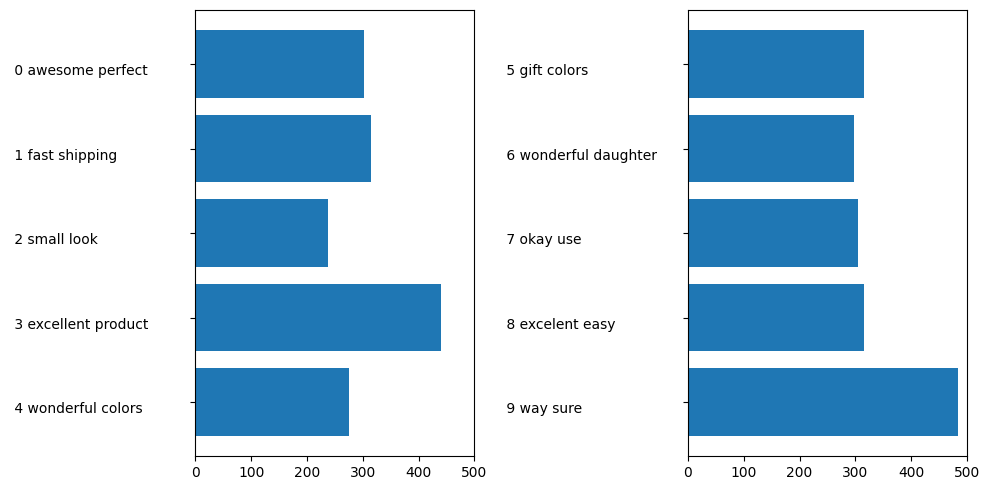

In [5]:
# Summing the document_topics over all reviews. 
# Each topic is named by the two most common words. 

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]

# Two column bar chart:
for col in [0, 1]:
    start = col * 5
    end = (col + 1) * 5
    ax[col].barh(np.arange(5), np.sum(pos_comment_topics, axis=0)[start:end])
    ax[col].set_yticks(np.arange(5))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 500)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)

plt.tight_layout()
plt.show()

In [7]:
pyLDAvis.lda_model.prepare(lda,X,vectorizer)
# Topic 1 Positive feedback on sewing machine and its size including analogous crafts
# Topic 2 Kids arts and craft and thier stationary gift items
# Topic 3 Product feedback on products
# Topic 4 Positive sentiment on arts and craft
# Topic 5 Positive sentiment on craft products focused on appearence
# Topic 6 Positive sentiment on craft products focused on their function like texture coloring and gluing
# Topic 7 Positive feedback on shipping
# Topic 8 Positive Sentiments with seller interactions and product
# Topic 9 Painting stationary items possibly related to oil painting, coloring and brushes
# Topic 10 Postivie and negative experiences related to decoration crafting projects

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.082955 -0.041598       1        1  18.696733
5     -0.072472 -0.037472       2        1  10.612565
7     -0.032827 -0.031744       3        1  10.367924
0     -0.025598 -0.045654       4        1   9.831816
8     -0.030422 -0.055701       5        1   9.763068
4     -0.064793 -0.023445       6        1   8.853789
1      0.066237  0.274335       7        1   8.822340
3      0.376210 -0.081600       8        1   8.406138
6     -0.043907  0.104761       9        1   7.560977
2     -0.089475 -0.061880      10        1   7.084651, topic_info=           Term        Freq       Total Category  logprob  loglift
323   excellent  413.000000  413.000000  Default  30.0000  30.0000
1089  wonderful  168.000000  168.000000  Default  29.0000  29.0000
350        fast   72.000000   72.000000  Default  28.0000  28.0000
877    shipping   46.000000   46.000000  Default  27.0000  27.0000
266   described   39.000000   39.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
413       great    3.591453   22.323267  Topic10  -4.9868   0.8202
1089  wonderful    4.614458  168.978378  Topic10  -4.7361  -0.9533
736      pretty    3.627138   27.426742  Topic10  -4.9769   0.6242
304        easy    3.616132   47.110163  Topic10  -4.9799   0.0802
577      making    3.228154   19.995327  Topic10  -5.0934   0.8237

[566 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         2  0.785116       10
1         3  0.098139       10
1         4  0.098139       10
2         1  0.195149      100
2         4  0.585447      100
...     ...       ...      ...
1108      9  0.395670     yarn
1108     10  0.060872     yarn
1109      5  0.629760    yarns
1109      9  0.209920    yarns
1116      5  0.598325  zippers

[1161 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 8, 1, 9, 5, 2, 4, 7, 3])

### 20 Topics


In [8]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english',binary=True)

X = vectorizer.fit_transform(one_text_data)

# Learning 20 topics
lda20 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                max_iter=25, random_state=0)
pos_comment_topics20 = lda20.fit_transform(X)
print("lda.components_.shape: {}".format(lda20.components_.shape))

sorting = np.argsort(lda20.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer:
feature_names20 = np.array(vectorizer.get_feature_names_out())
print(feature_names20[sorting])

lda.components_.shape: (20, 1117)
[['pretty' 'little' 'useful' ... 'stays' 'stencils' 'zippers']
 ['delivery' 'fast' 'loved' ... 'excelente' 'excelent' 'punches']
 ['fun' 'didn' 'realize' ... 'olfa' 'tablet' 'properly']
 ...
 ['value' 'amazing' 'favorite' ... 'music' 'logger' 'expansion']
 ['came' 'quickly' 'product' ... 'higher' 'grid' 'zippers']
 ['small' 'priced' 'awesome' ... 'excelente' 'bucks' 'professionals']]


In [9]:
# Print out the 20 topics:
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names20,
                           sorting=sorting, topics_per_chunk=5, n_words=10)
# Topic 0 Positive sentiment on product quality and appearance
# Topic 1 Positive feedback on delivery speed and satisfaction
# Topic 2 Positive sentiment on enjoyable crafting activities
# Topic 3 Positive feedback on product quality and recommendations
# Topic 4 Positive sentiment on paint products
# Topic 5 Positive sentiment on crafting supplies variety 
# Topic 6 Positive feedback on fabric quality and craft
# Topic 7 Neutral feedback on fabric quality and craft
# Topic 8 Positive sentiment on sewing and knitting machines
# Topic 9 --------unsure... desire want and expectations?
# Topic 10 Christmas-themed crafts and gifts
# Topic 11 Positive sentiment on crafting projects and their outcomes
# Topic 12 Positive feedback on ease of use and results of crafting materials
# Topic 13 Positive sentiment on appearence of items crafts
# Topic 14 --------unsure...
# Topic 15 seems to contain lots of action words regarding using and buying
# Topic 16 Positive sentiment on expectations of items and descriptions
# Topic 17 Positive feedback on product value 
# Topic 18 Positive sentiment on product descriptions and their accuracy
# Topic 19 Small-sized crafting items

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
pretty        delivery      fun           product       paint         
little        fast          didn          quality       color         
useful        loved         realize       excellent     happy         
quality       pleased       work          buy           set           
colors        just          color         recommend     worked        
fine          holes         apart         service       canvas        
return        satisfied     die           highly        wonderful     
color         doesn         look          seller        acrylic       
really        pour          like          price         buy           
designs       sister        wonderful     good          stamp         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
need

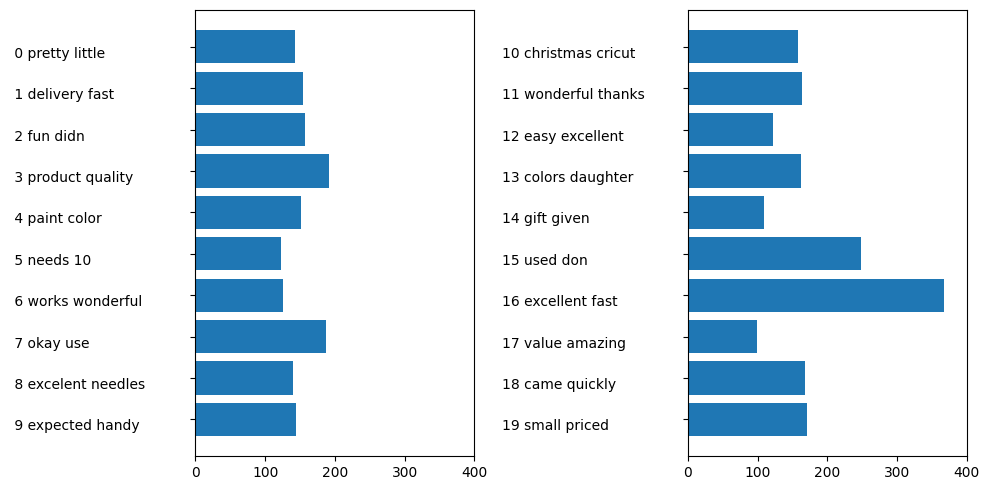

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Topic_names for 20 topics
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names20[sorting[:, :2]])]

# two column bar chart:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(pos_comment_topics20, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 400)  
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130) 
plt.tight_layout()

In [27]:
pyLDAvis.lda_model.prepare(lda20,X,vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.065370  0.072161       1        1  9.000836
18     0.049341  0.119434       2        1  7.932095
16    -0.426648  0.008555       3        1  7.234541
7      0.053750  0.090945       4        1  5.586272
10     0.077424  0.054951       5        1  5.293741
13     0.044565 -0.007039       6        1  5.247022
19     0.050623  0.120236       7        1  5.107457
0      0.057807  0.006060       8        1  5.050773
3     -0.238080  0.058105       9        1  5.046885
9      0.017900  0.067786      10        1  4.976711
1     -0.004554 -0.012698      11        1  4.662678
12    -0.001404  0.047001      12        1  4.658675
4      0.021999 -0.003163      13        1  4.406388
2      0.082492 -0.013797      14        1  4.214878
5      0.068484 -0.047472      15        1  4.043504
8      0.027876  0.031448      16        1  3.939387
14     0.021419 -0.107005      17        1  3.694411
11     0.004003 -0.277225      18        1  3.526779
6      0.006595 -0.122377      19        1  3.405308
17     0.021035 -0.085907      20        1  2.971658, topic_info=           Term        Freq       Total Category  logprob  loglift
323   excellent  386.000000  386.000000  Default  30.0000  30.0000
1089  wonderful  168.000000  168.000000  Default  29.0000  29.0000
748     product   86.000000   86.000000  Default  28.0000  28.0000
770     quality   67.000000   67.000000  Default  27.0000  27.0000
321    excelent   31.000000   31.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
686     pattern    1.591944   10.198866  Topic20  -4.9106   1.6587
859         set    1.816512   28.897951  Topic20  -4.7786   0.7492
754    projects    1.710752   22.912950  Topic20  -4.8386   0.9213
323   excellent    2.066977  386.673051  Topic20  -4.6494  -1.7154
132         buy    1.599329   49.774437  Topic20  -4.9059   0.0781

[953 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.094941       10
1         7  0.094941       10
1        15  0.284822       10
1        17  0.379763       10
2         8  0.580141      100
...     ...       ...      ...
1111     10  0.220742    years
1111     17  0.110371    years
1112     14  0.687666   yellow
1116      1  0.289864  zippers
1116     16  0.579727  zippers

[1959 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 19, 17, 8, 11, 14, 20, 1, 4, 10, 2, 13, 5, 3, 6, 9, 15, 12, 7, 18])

## Five Star Reviews


In [12]:
five_text_data=new_df[new_df['overall'] == 5]['Review']
five_text_data

0                    Wonderful asst. of  wood carving tools
1         Pretty lace with 4 way stretch. I was exactly ...
4         I bought this for a costume i was making. i wa...
5                        Great idea but they don't cut well
6                                         Love this thread.
                                ...                        
123617    I don't know that I can fully express my adora...
123618    Love this works well with machine. Good packag...
123619       It is what it is. It works. Made of cardboard.
123620    Really cool. It's durable, lightweight and ver...
123621                          Great hammer fro the price.
Name: Review, Length: 101438, dtype: object

### 10 Topics


In [13]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english',binary=True)

X = vectorizer.fit_transform(five_text_data)

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
pos_comment_topics = lda.fit_transform(X)

feature_names = np.array(vectorizer.get_feature_names_out())

sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
print(feature_names[sorting])

[['described' 'wanted' 'just' ... 'wooow' 'summed' '1star']
 ['nice' 'like' 'beads' ... 'wooow' 'summed' '1star']
 ['great' 'perfect' 'yarn' ... 'primaries' 'wooow' 'summed']
 ...
 ['use' 'stuff' 'used' ... 'summed' 'wooow' '1star']
 ['thank' 'beautiful' 'fast' ... 'lyra' 'patons' '1star']
 ['use' 'great' 'like' ... 'summed' 'wooow' '1star']]


In [15]:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
described     nice          great         ok            love          
wanted        like          perfect       paint         expected      
just          beads         yarn          colors        needed        
exactly       pretty        work          great         just          
cute          great         needles       color         exactly       
job           quality       worked        love          looking       
stamp         good          soft          brush         color         
does          jewelry       love          use           wife          
stamps        colors        color         set           colors        
great         love          project       pencils       perfect       


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
love

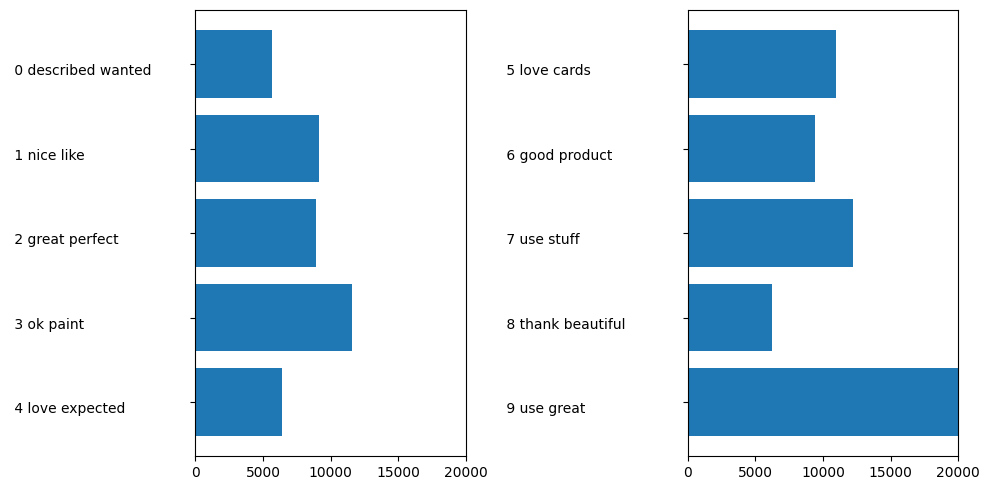

In [16]:
# Summing the document_topics over all reviews. 
# Each topic is named by the two most common words. 

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]

# Two column bar chart:
for col in [0, 1]:
    start = col * 5
    end = (col + 1) * 5
    ax[col].barh(np.arange(5), np.sum(pos_comment_topics, axis=0)[start:end])
    ax[col].set_yticks(np.arange(5))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 20000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)

plt.tight_layout()
plt.show()

In [17]:
pyLDAvis.lda_model.prepare(lda,X,vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.111244 -0.096079       1        1  28.524725
7     -0.123193 -0.092124       2        1  14.422913
3     -0.096497 -0.094507       3        1  13.137507
5     -0.105690 -0.079946       4        1  10.523419
1      0.009123 -0.093578       5        1   7.227397
2      0.018069 -0.051349       6        1   6.733185
6      0.359732 -0.021301       7        1   5.993240
8      0.182546  0.027131       8        1   4.735229
0     -0.054047  0.178694       9        1   4.382654
4     -0.078799  0.323059      10        1   4.319732, topic_info=         Term         Freq        Total Category  logprob  loglift
5484     love  5226.000000  5226.000000  Default  30.0000  30.0000
4097     good  3784.000000  3784.000000  Default  29.0000  29.0000
4184    great  6583.000000  6583.000000  Default  28.0000  28.0000
7038  product  2782.000000  2782.000000  Default  27.0000  27.0000
6095     nice  2874.000000  2874.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
8319     size    73.512076   878.569819  Topic10  -5.1538   0.6611
5065     kids    41.082844   195.002385  Topic10  -5.7356   1.5846
6294    order    53.926912   566.683505  Topic10  -5.4636   0.7898
2226    craft    47.072080   405.790893  Topic10  -5.5995   0.9878
4184    great    49.544863  6583.174926  Topic10  -5.5483  -1.7474

[775 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
29         5  0.911326     12mm
118        2  0.109282      364
118       10  0.764973      364
189        5  0.901317      651
246        4  0.966605       a2
...      ...       ...      ...
10436      5  0.011802    years
10436      6  0.051143    years
10464      9  0.863764     yupo
10483      1  0.383298  zippers
10483      8  0.610438  zippers

[1996 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 4, 6, 2, 3, 7, 9, 1, 5])

### 20 Topics


In [18]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

X = vectorizer.fit_transform(one_text_data)

# Learning 20 topics
lda20 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                max_iter=25, random_state=0)
pos_comment_topics20 = lda20.fit_transform(X)
print("lda.components_.shape: {}".format(lda20.components_.shape))

sorting = np.argsort(lda20.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names20 = np.array(vectorizer.get_feature_names_out())
print(feature_names20[sorting])

lda.components_.shape: (20, 1117)
[['pretty' 'little' 'fine' ... 'grid' 'blocks' 'overlay']
 ['delivery' 'fast' 'pleased' ... 'markings' 'dollar' 'tree']
 ['blue' 'realize' 'didn' ... 'cons' 'logger' 'blocks']
 ...
 ['value' 'pencils' 'amazing' ... 'tablet' 'purple' 'music']
 ['came' 'quickly' 'product' ... 'glow' 'gel' 'loom']
 ['small' 'priced' 'way' ... 'inking' 'waste' 'gel']]


In [22]:
# Print out the 20 topics:
mglearn.tools.print_topics(topics=range(20), feature_names=feature_names20,
                           sorting=sorting, topics_per_chunk=5, n_words=10)


topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
pretty        delivery      blue          product       color         
little        fast          realize       quality       paint         
fine          pleased       didn          excellent     canvas        
colors        wonderful     light         buy           brushes       
useful        loved         apart         recommend     wonderful     
small         picture       colors        service       fun           
pattern       cards         green         seller        worked        
quality       just          dries         highly        acrylic       
smaller       brand         wow           good          patterns      
color         pour          grey          price         enjoy         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
size

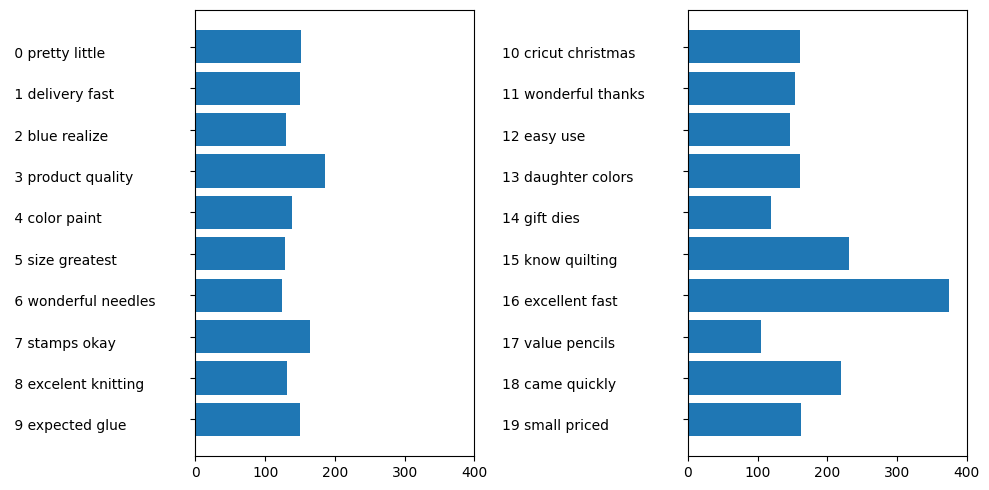

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Adjust topic_names for 20 topics
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names20[sorting[:, :2]])]

# two column bar chart:
for col in [0, 1]:
    start = col * 10
    end = (col + 1) * 10
    ax[col].barh(np.arange(10), np.sum(pos_comment_topics20, axis=0)[start:end])
    ax[col].set_yticks(np.arange(10))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 400)  
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130) 
plt.tight_layout()

In [25]:
pyLDAvis.lda_model.prepare(lda20,X,vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.065370  0.072161       1        1  9.000836
18     0.049341  0.119434       2        1  7.932095
16    -0.426648  0.008555       3        1  7.234541
7      0.053750  0.090945       4        1  5.586272
10     0.077424  0.054951       5        1  5.293741
13     0.044565 -0.007039       6        1  5.247022
19     0.050623  0.120236       7        1  5.107457
0      0.057807  0.006060       8        1  5.050773
3     -0.238080  0.058105       9        1  5.046885
9      0.017900  0.067786      10        1  4.976711
1     -0.004554 -0.012698      11        1  4.662678
12    -0.001404  0.047001      12        1  4.658675
4      0.021999 -0.003163      13        1  4.406388
2      0.082492 -0.013797      14        1  4.214878
5      0.068484 -0.047472      15        1  4.043504
8      0.027876  0.031448      16        1  3.939387
14     0.021419 -0.107005      17        1  3.694411
11     0.004003 -0.277225      18        1  3.526779
6      0.006595 -0.122377      19        1  3.405308
17     0.021035 -0.085907      20        1  2.971658, topic_info=           Term        Freq       Total Category  logprob  loglift
323   excellent  386.000000  386.000000  Default  30.0000  30.0000
1089  wonderful  168.000000  168.000000  Default  29.0000  29.0000
748     product   86.000000   86.000000  Default  28.0000  28.0000
770     quality   67.000000   67.000000  Default  27.0000  27.0000
321    excelent   31.000000   31.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
686     pattern    1.591944   10.198866  Topic20  -4.9106   1.6587
859         set    1.816512   28.897951  Topic20  -4.7786   0.7492
754    projects    1.710752   22.912950  Topic20  -4.8386   0.9213
323   excellent    2.066977  386.673051  Topic20  -4.6494  -1.7154
132         buy    1.599329   49.774437  Topic20  -4.9059   0.0781

[953 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.094941       10
1         7  0.094941       10
1        15  0.284822       10
1        17  0.379763       10
2         8  0.580141      100
...     ...       ...      ...
1111     10  0.220742    years
1111     17  0.110371    years
1112     14  0.687666   yellow
1116      1  0.289864  zippers
1116     16  0.579727  zippers

[1959 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 19, 17, 8, 11, 14, 20, 1, 4, 10, 2, 13, 5, 3, 6, 9, 15, 12, 7, 18])